In [13]:
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import numpy as np
import sys
%matplotlib inline

In [14]:
def time_in_seconds(val):
    if "-" in val:
        fields = val.split("-")
        sec=0.0
        for i in fields:
            if "s" in i: sec += float(i.strip("s"))
            if "m" in i: sec += 60 * float(i.strip("m"))
            if "h" in i: sec += 3600 * float(i.strip("h"))
        return sec
    else:
        return float(val.strip("s"))

In [15]:
def parse_report(file_name):
    buffer = []
    resources_dict = {
        "MPI Cores": "mpi", "Threads per core": "thrs", "Threads total": "thr_tot", 
        "Nodes Computing": "nodes", "Nodes IO": "nodes_io", "MPI tasks / GPU": "mpi/gpu",
    }
    resources = {}
    timing = {}
    log = False
    with open(file_name, 'r') as report:
        for line in report:
            if line == "\n": log = False
            if log: 
                buffer.append(line.strip())
            else:
                for key, val in resources_dict.items():
                    if key in line: resources[val] = int(line.strip().split(":")[1])
                if "Time-Profile" in line:
                    timing["Time-Profile"] = time_in_seconds(line.strip().split(":")[1])

            if "Clock:" in line: log = True

    for line in buffer:
        fields = line.split(":")
        timing[fields[0].strip()] = time_in_seconds(fields[1].strip().split()[0])
    return resources, timing

In [16]:
def build_dataframe(x_axis='mpi', factor=1, rename_cols={}):
    r_files = glob("r-*")

    data = {}
    for report in r_files:
        resources, timing = parse_report(report)
        for key, val in resources.items():
            if key in data:
                data[key].append(val)
            else:
                data[key] = [val,]
        for key, val in timing.items():
            if key in data:
                data[key].append(val)
            else:
                data[key] = [val,]
    
    scaling = pd.DataFrame(data)
    if rename_cols: 
        scaling.rename(columns=rename_cols, inplace=True)
    else:
        scaling.rename(columns={'Xo (procedure)': 'Xo', 'X (procedure)': 'X'}, inplace=True)
    scaling.sort_values(by=[x_axis], inplace=True)
    if 'mpi/gpu' in scaling: scaling['gpu'] = pd.Series(scaling['mpi'] / scaling['mpi/gpu'], dtype=np.int64)
    scaling['ideal'] = scaling[x_axis] / factor
    scaling['speedup'] = scaling[scaling[x_axis]>=factor]['Time-Profile'].max() / scaling['Time-Profile']
    scaling['efficiency'] = scaling.speedup / scaling.ideal * 100
    scaling['Self energy'] = scaling['HF'] + scaling['GW(ppa)']
    scaling['Other'] = scaling['Time-Profile'] - scaling['Dipoles'] - scaling['Xo'] - scaling['X'] - scaling['Self energy']
    scaling['node_h'] = scaling['nodes'] * scaling['Time-Profile'] / 3600
    return scaling

In [17]:
def build_scaling_plot(scaling, pile, colors, x_axis='mpi', x_label='MPI tasks', bar_width=1,
                       title=None, legend_loc=None, label=None, label_pos=None, efficiency=True, 
                       file_name='scaling.png', y_lim=None):
    if len(pile) != len(colors):
        sys.stderr.write("Error: the number of elements of pile and colors lists have to be the same.")
        return
    fig, ax1 = plt.subplots(figsize=(10, 7))

    bottom = pd.Series(dtype='float64')
    for key, color in zip(pile, colors):
        if bottom.empty:
            ax1.bar(scaling[x_axis], scaling[key], width=bar_width, color=color, label=key)
            bottom = scaling[key].copy()
        else:
            ax1.bar(scaling[x_axis], scaling[key], width=bar_width, color=color, label=key, bottom=bottom)
            bottom += scaling[key]

    ax1.set_xlabel(x_label,fontsize=20)
    ax1.set_ylabel('Time (sec)',fontsize=20)
    ax1.legend()
    if y_lim: ax1.set_ylim(y_lim)
    if legend_loc: ax1.legend(fontsize='18',framealpha=0.0, loc=legend_loc)
    ax1.tick_params(axis = 'both', which = 'major', labelsize = 18)
    if label and label_pos: ax1.text(*label_pos, label, fontsize=20)
    plt.xticks(scaling[x_axis])
    
    if efficiency:
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_ylim([-10, 110])
        ax2.set_ylabel('Efficiency (%)', color='tab:blue',fontsize=20)  # we already handled the x-label with ax1
        ax2.plot(scaling[x_axis], scaling['efficiency'], linewidth=3, color='tab:blue')
        ax2.tick_params(axis='y', labelcolor='tab:blue', labelsize=18)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    if title: plt.title(title, fontsize=20)
    plt.savefig(file_name, bbox_inches='tight')

In [18]:
def build_cost_plot(scaling, label='yambo', title=None, y_lim=None, file_name='cost.pdf'):
    fig2, ax3 = plt.subplots(figsize=(10, 7))
    ax3.set_xlabel('Time to solution (sec)',fontsize=20)
    ax3.set_ylabel('Cost (node*hour)',fontsize=20)
    ax3.plot(scaling['Time-Profile'][2:], scaling['node_h'][2:], 
             linewidth=3, color=colors[0], marker='.', markersize=15,
             label=label)
    if y_lim: ax3.set_ylim(y_lim)
    ax3.legend()
    ax3.legend(fontsize='18',framealpha=0.0)

    if title: plt.title(title, fontsize=20)
    plt.savefig(file_name)

In [19]:
scaling = build_dataframe(x_axis='mpi', factor=20)
scaling.to_csv('scaling.csv', sep='\t')
scaling

mpi  thrs  thr_tot  nodes  nodes_io  mpi/gpu  Time-Profile  \
10    4     8       32      1         1        1        5100.0   
6    20     8      160      5         1        1        1361.0   
1    40     8      320     10         1        1         774.0   
2    60     8      480     15         1        1         556.0   
7    80     8      640     20         1        1         441.0   
4   100     8      800     25         1        1         358.0   
8   120     8      960     30         1        1         328.0   
9   140     8     1120     35         1        1         285.0   
0   160     8     1280     40         1        1         258.0   
3   180     8     1440     45         1        1         246.0   
5   200     8     1600     50         1        1         227.0   

    io_ATMPROJ_pwscf  io_KB_abinit   io_BS  ...  DIPOLE_transverse         Xo  \
10            0.0001        0.0001  0.0002  ...          1876.0000  2414.0000   
6             0.0001        0.0001  0.0003  ...           393.9175   777.0000   
1             0.0001        0.0001  0.0003  ...           209.4525   455.4877   
2             0.0002        0.0002  0.0005  ...           148.4357   324.4857   
7             0.0001        0.0002  0.0003  ...           117.5085   254.0378   
4             0.0001        0.0002  0.0003  ...            98.9623   197.9958   
8             0.0001        0.0002  0.0003  ...            86.9956   183.7931   
9             0.0002        0.0002  0.0003  ...            77.3652   153.4539   
0             0.0001        0.0002  0.0003  ...            71.6816   133.0946   
3             0.0001        0.0001  0.0004  ...            66.6651   130.2942   
5             0.0001        0.0002  0.0004  ...            62.2536   116.2699   

      Dipoles  gpu  ideal   speedup  efficiency  Self energy    Other  \
10  1879.0000    4    0.2  0.266863  133.431373     780.7836  21.8979   
6    397.1855   20    1.0  1.000000  100.000000     159.3552  23.9313   
1    213.2750   40    2.0  1.758398   87.919897      81.1500  20.3603   
2    152.4184   60    3.0  2.447842   81.594724      56.4944  18.8131   
7    121.5582   80    4.0  3.086168   77.154195      42.6529  19.0556   
4    103.3167  100    5.0  3.801676   76.033520      34.7814  18.1519   
8     91.2371  120    6.0  4.149390   69.156504      29.8318  19.2398   
9     81.9063  140    7.0  4.775439   68.220551      27.4232  18.4796   
0     76.2563  160    8.0  5.275194   65.939922      24.2360  19.6041   
3     71.4286  180    9.0  5.532520   61.472448      22.0923  18.5019   
5     67.0105  200   10.0  5.995595   59.955947      20.3843  19.6267   

      node_h  
10  1.416667  
6   1.890278  
1   2.150000  
2   2.316667  
7   2.450000  
4   2.486111  
8   2.733333  
9   2.770833  
0   2.866667  
3   3.075000  
5   3.152778  

[11 rows x 52 columns]

In [20]:
colors=['#2EA6A6', '#F28F38', '#47AB6C', '#112F41', '#D90718']
pile = ['Dipoles', 'Xo', 'X', 'Self energy', 'Other']
scaling[['mpi', 'Time-Profile'] + pile]

mpi  Time-Profile    Dipoles         Xo       X  Self energy    Other
10    4        5100.0  1879.0000  2414.0000  4.3185     780.7836  21.8979
6    20        1361.0   397.1855   777.0000  3.5280     159.3552  23.9313
1    40         774.0   213.2750   455.4877  3.7270      81.1500  20.3603
2    60         556.0   152.4184   324.4857  3.7884      56.4944  18.8131
7    80         441.0   121.5582   254.0378  3.6955      42.6529  19.0556
4   100         358.0   103.3167   197.9958  3.7542      34.7814  18.1519
8   120         328.0    91.2371   183.7931  3.8982      29.8318  19.2398
9   140         285.0    81.9063   153.4539  3.7370      27.4232  18.4796
0   160         258.0    76.2563   133.0946  4.8090      24.2360  19.6041
3   180         246.0    71.4286   130.2942  3.6830      22.0923  18.5019
5   200         227.0    67.0105   116.2699  3.7086      20.3843  19.6267

In [11]:
scaling[['mpi', 'nodes', 'Time-Profile', 'efficiency', 'node_h']].to_csv('rutile_benchmark.csv', sep='\t')

In [9]:
build_scaling_plot(scaling=scaling, 
                   pile=pile, colors=colors, bar_width=10, efficiency=True,
                   legend_loc='upper right', title=r'JuwelsBooster, X(10Ry), Yambo v5.1(dev)', 
                   file_name='scaling_1nodes.png', y_lim=[0,5200])

In [12]:
build_scaling_plot(scaling=scaling[scaling['mpi']>=20], 
                   pile=pile, colors=colors, bar_width=10, efficiency=True,
                   legend_loc='upper right', title=r'JuwelsBooster, X(10Ry), Yambo v5.1(dev)', 
                   file_name='scaling_5nodes_rescaled.png', y_lim=[0,1800])

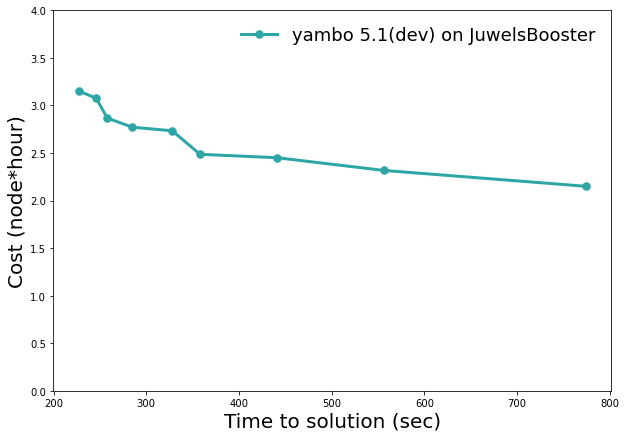

In [15]:
build_cost_plot(scaling=scaling, label='yambo 5.1(dev) on JuwelsBooster', y_lim=[0,4.0])

In [21]:
scaling[['mpi', 'nodes', 'Time-Profile'] + pile].to_latex('strong_scaling.tex', index=False)